# Fire Spread Simulation
## Introduction
This notebook is based on the `fire` model implementation with NetLogo. You can find the original implementation at https://ccl.northwestern.edu/netlogo/models/Fire. This model aims to showcase basic methods that allow interactions between agents. 

The model simulates the spread of a fire in a forest. The fire spreads from tree to nearby trees. The model consist of a grid of any given size, where each cell may contain either one or no tree. The fire spreads to nearby trees only. The state of each tree is then represented graphically by the color of the cell. Untouched trees appear on green patches, burning trees appear on red patches, and burnt trees appear on orange patches. Whenever there is no tree on a patch, the patch is colored black.

In [1]:
from matplotlib import pyplot as plt

from abses.cells import PatchCell, raster_attribute
from abses.main import MainModel
from abses.nature import PatchModule
from abses.sequences import ActorsList

As usual, the basis of any ABSESpy model are the MainModel. For these specific model we won't use the `Actor` class. Instead, we will rely heavily on the capabilities of the `PatchCell` class, part of the ABSESpy library. 

We must implement a class that will control, contain and manage global level variables and objects such as the grid of the cells. That is the task the `Forest` class which will inherit from the `MainModel` class. Then, we also need the implementation of our agents. That is the task of the `Tree` class, which will inherit from the `PatchCell` class.

```python
class Tree(PatchCell):
    (...)

class Forest(MainModel):
    (...)
```

## The `Tree` class

The `Tree` class, which inherits from the `PatchCell` class, will contain the logic for all trees. A tree will consist of a full cell and, thus, it will not have agency but will rather be affected by its immediate environment. The indicator for how a tree is being affected consist of the state the tree is in. The state of a tree can be one of the following:
- 0: Empty patch cell
- 1: Healthy tree
- 2: Burning tree
- 3: Scorched tree

The `Tree` class will contain the logic for the spread of the fire. The spread of the fire will be determined by the state of the tree and the state of the neighboring trees. This process will follow simple, heuristic rules. Any tree that is burning will spread the fire to any neighboring tree that is healthy. A neighbor is defined as those tree standing on the cells at most 1 unit distance away.

In [2]:
class Tree(PatchCell):
    """
    Breed `Tree` is a subclass of `PatchCell`.
    It has four different states:
    0: empty, i.e., no tree is located on the patch.
    1: has an intact tree.
    2: the tree here is burning now.
    3: the three here is burned and now scorched -cannot be burned again.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._state = 0

    def burning(self):
        """If the tree is burning, it ignites the neighboring trees."""
        if self._state == 2:
            neighbors = self.neighboring(moore=False, radius=1)
            # apply to all neighboring patches: trigger ignite method
            neighbors.select({"state": 1}).trigger("ignite")
            # after then, it becomes scorched and cannot be burned again.
            self._state = 3

    def grow(self) -> None:
        """Grows the tree here."""
        self._state = 1

    def ignite(self) -> None:
        """Ignite this tree."""
        if self._state == 1:
            self._state = 2

    @raster_attribute
    def state(self) -> int:
        """Return the state code."""
        return self._state

## The `Forest` MainModel Class
The forest class will contain the grid of tree cells. The forest class is also responsible for setting up the initial configuration of the model as well as activate the rules for the spread of the fire. As usual, the `Forest` class will inherit from the `MainModel` class and we need to specify what the setup and step methods will be. 

The setup method in the Forest class is responsible for creating the initial state of the forest. It's like the stage director setting the scene before the play begins. This method sets up the grid that represents the forest and populates it with trees. The placement and characteristics of these trees are determined by the initial configuration parameters of the model. Once the setup method has run, the forest is ready for the simulation to begin.

The step method in the Forest class is like the director calling "Action!" on a movie set. It's responsible for advancing the state of the forest by one time step.

In the context of a forest fire simulation, the step method would typically iterate over all the trees in the forest and update their state based on the rules of the simulation. For example, if a tree is on fire, it might spread the fire to its neighboring trees. If a tree has been burning for a certain amount of time, it might turn into ash.

The step method is called repeatedly to simulate the passage of time and the spread of the fire through the forest. Each call to the step method represents a new moment in time in the life of the forest.

Besides those two methods, we want another one that will allow us to visualize the current state of the forest. It will serve the purpose of letting us have a glimpse of the macro state emerging from the simple, micro interactions of the trees.

In [3]:
import numpy as np


class Forest(MainModel):
    """
    Forest model where fire
    """

    def setup(self) -> None:
        # setup a grid space.
        grid: PatchModule = self.nature.create_module(
            how="from_resolution",
            name="forest",
            shape=self.params.shape,
            cell_cls=Tree,
            major_layer=True,
        )
        # random choose some patches to setup trees
        chosen_patches = grid.random.choice(self.num_trees, replace=False)
        # create trees on the selected patches.
        chosen_patches.trigger("grow")
        # ignite the trees in the leftmost column.
        ActorsList(self, grid.array_cells[:, 0]).trigger("ignite")

    def step(self):
        for tree in self.nature.forest:
            tree.burning()

    @property
    def burned_rate(self) -> float:
        """The burned trees in ratio."""
        state = self.nature.major_layer.get_raster("state")
        return np.squeeze(state == 3).sum() / self.num_trees

    @property
    def num_trees(self) -> int:
        """Number of trees"""
        shape = self.params.shape
        return int(shape[0] * shape[1] * self.params.density)

    def plot_state(self):
        """Plot the state of trees."""
        categories = {
            0: "black",
            1: "green",
            2: "orange",
            3: "red",
        }
        cmap = plt.cm.colors.ListedColormap(
            [categories[i] for i in sorted(categories)]
        )
        data = self.nature.get_xarray("state")
        data.plot(cmap=cmap)
        plt.show()

## Simulations and Discussion

In this section, we will be using the Forest and Tree classes to simulate forest fires and study their behavior under different conditions. Our primary focus will be on understanding the relationship between the density of the forest and the speed at which the fire spreads.

The Forest class represents a forest in which a fire can spread. Each tree in the forest is represented by an instance of the Tree class, which can be in one of four states: empty, intact, burning, or scorched.

Our hypothesis is that the density of the forest will have a significant impact on the speed of fire spread. Specifically, we expect that a less dense forest will slow down the fire spread due to the larger gaps between trees. Conversely, in a denser forest, we expect the fire to spread more quickly due to the closer proximity of trees.

To test this hypothesis, we will run simulations with different forest densities and observe the speed of fire spread in each case. We will use the Forest class to set up the forest and the Tree class to simulate the behavior of individual trees. The density of the forest will be controlled by the density parameter of the Forest class..

#### 60% Tree Population Density

For this level of the density parameter, we expect the forest to be relatively dense, with trees close to each other. We expect the fire to spread quickly due to the close proximity of trees.

Our suspicion is confirmed in that, by the final step of the simulation, the fire has spread to cover most of the populated area of the forest. More over, the fire has not stopped spreading.

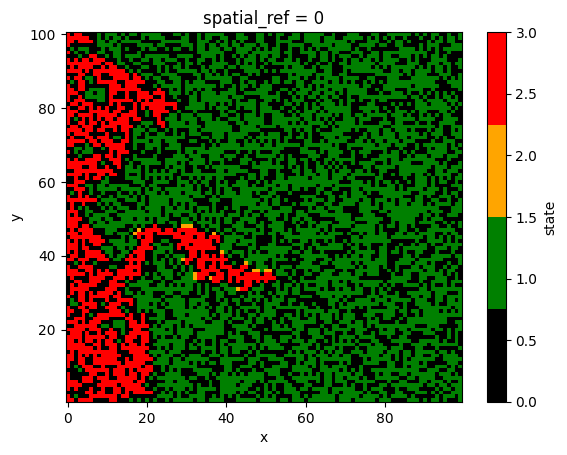

In [4]:
cfg = {"model": {"density": 0.6, "shape": (100, 100)}, "time": {"end": 25}}

# Instantiate the model and set it up.
model = Forest(parameters=cfg)
# Run and plot final state
model.run_model()
model.plot_state()

#### 40% Tree Population Density

This level of the density parameter represents a less dense forest, with more space between trees. We expect the fire to spread more slowly than in the previous case, due to the larger gaps between trees. Nonetheless, it is not considerable low. 

Not a quarter of the forest is covered by the fire. The fire has stopped spreading by the final step of the simulation.

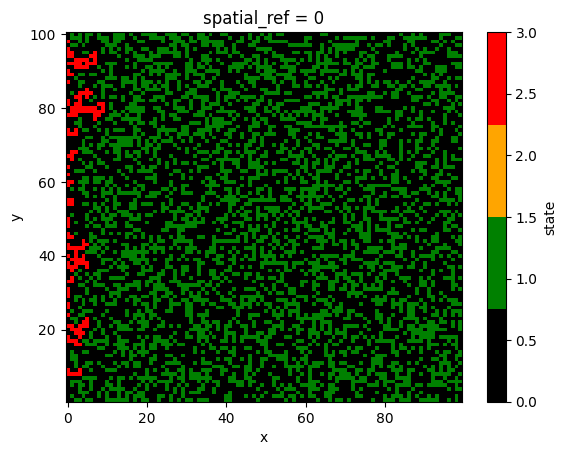

In [5]:
cfg = {
    "model": {"density": 0.4, "shape": (100, 100)},
    "time": {"end": 25},
    "reports": {"final": {"burned": "burned_rate"}},
}

# Instantiate the model and set it up.
model = Forest(parameters=cfg)
# Run and plot final state
model.run_model()
model.plot_state()

## Experiment for different parameters

In this session, we are going explore how the key parameter "density" of trees in the forest affects the spread of the fire. We will run simulations with different values of the density parameter and observe the speed of fire spread in each case. 

In [6]:
from abses import Experiment

exp = Experiment(Forest)

First of all, we import the `Experiment` object from the `ABSESpy` library for batch run.

Since the `Forest` model is defined in this notebook, we cannot use multiple processing to run the simulations. We will use the `Experiment` object to run the simulations sequentially.

In [7]:
exp.batch_run(cfg=cfg, repeats=10, parallels=1)
exp.clean()  # clean the results.

  0%|          | 0/10 [00:00<?, ?it/s]

Next, we would try to use different parameters of `model.density`.

In [8]:
exp.batch_run(
    cfg=cfg,
    repeats=10,
    parallels=1,
    overrides={"model.density": np.arange(0.1, 1.01, 0.1)},
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
exp.summary()

,burned,job_id,repeat_id,model.density
0,0.008,0,1,0.1
1,0.013,0,2,0.1
2,0.008,0,3,0.1
3,0.011,0,4,0.1
4,0.011,0,5,0.1
...,...,...,...,...
95,1.000,9,6,1.0
96,1.000,9,7,1.0
97,1.000,9,8,1.0
98,1.000,9,9,1.0


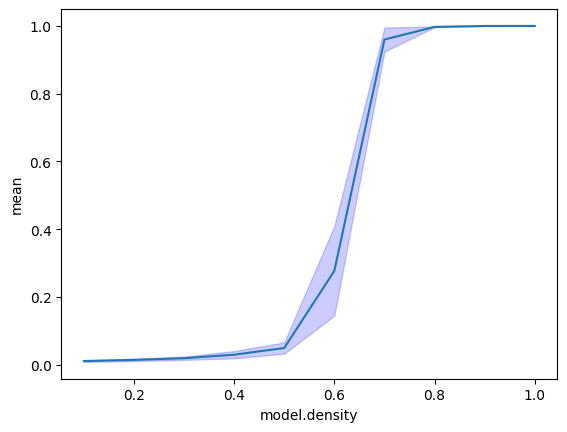

In [10]:
import seaborn as sns


def plot_exp_result(exp):
    df = exp.summary()
    grouped = df.groupby("model.density")["burned"].agg(["mean", "std"])
    sns.lineplot(grouped, x=grouped.index, y="mean", err_style="band")
    plt.fill_between(
        grouped.index,
        grouped["mean"] - grouped["std"],
        grouped["mean"] + grouped["std"],
        color="blue",
        alpha=0.2,
    )
    plt.show()


plot_exp_result(exp=exp)

## Call experiment in CLI

As we can see, since the model was imported from an outside script, we are now able to use multiple processes for faster batch run.

In [11]:
from examples.fire_spread.model import Forest
from abses import Experiment

exp = Experiment.new(Forest)
exp.results

[]

In [12]:
exp.batch_run(cfg=cfg, parallels=3, repeats=100)
exp.summary()

  0%|          | 0/100 [00:00<?, ?it/s]

,burned,job_id,repeat_id
0,0.02725,0,1
1,0.03100,0,2
2,0.03225,0,3
3,0.03050,0,4
4,0.02625,0,5
...,...,...,...
95,0.02225,0,96
96,0.03925,0,97
97,0.02200,0,98
98,0.03100,0,99


Despite we used a dictionary of parameters to run the previous simulation, `ABSESpy` always encourage users to save the configurations in a `YAML` file for better organization and reusability. We will use the `YAML` file to store the parameters for the later simulations.

```yaml
exp:
  name: fire_spread
  repeats: 100

reports:
  final:
    burned: "burned_rate"


model:
  density: 0.45
  shape:
    - 100
    - 100

time:
  end: 25
```

Furthermore, for multiple-processes run, it's also good to save the model `Forest` in a `.py` script and import it in `Notebook` or `CLI`.

This is our working tree:


In [13]:
# before a new batch run, we may want to clean the previous results...
exp.clean()

# Now, we use the configurations from the `yaml` settings file.
CONFIG_PATH = r"../../../examples/fire_spread/config.yaml"

# Just simply pass it as the cfg.
exp.batch_run(cfg=CONFIG_PATH)
exp.summary()

  0%|          | 0/11 [00:00<?, ?it/s]

,burned,job_id,repeat_id
0,0.03150,0,1
1,0.02675,0,2
2,0.01875,0,3
3,0.01950,0,4
4,0.02000,0,5
5,0.02500,0,6
6,0.01775,0,7
7,0.01800,0,8
8,0.05550,0,9
9,0.02550,0,10


In [14]:
exp.summary()

,burned,job_id,repeat_id
0,0.03150,0,1
1,0.02675,0,2
2,0.01875,0,3
3,0.01950,0,4
4,0.02000,0,5
5,0.02500,0,6
6,0.01775,0,7
7,0.01800,0,8
8,0.05550,0,9
9,0.02550,0,10


In [15]:
exp.clean(new_exp=True)

In [16]:
exp.batch_run(
    cfg=CONFIG_PATH,
    parallels=5,
    overrides={"model.density": np.arange(0.1, 1.01, 0.1)},
)
exp.summary()

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,burned,job_id,repeat_id,model.density
0,0.008,0,1,0.1
1,0.011,0,2,0.1
2,0.006,0,3,0.1
3,0.016,0,4,0.1
4,0.016,0,5,0.1
...,...,...,...,...
105,1.000,9,7,1.0
106,1.000,9,8,1.0
107,1.000,9,9,1.0
108,1.000,9,10,1.0


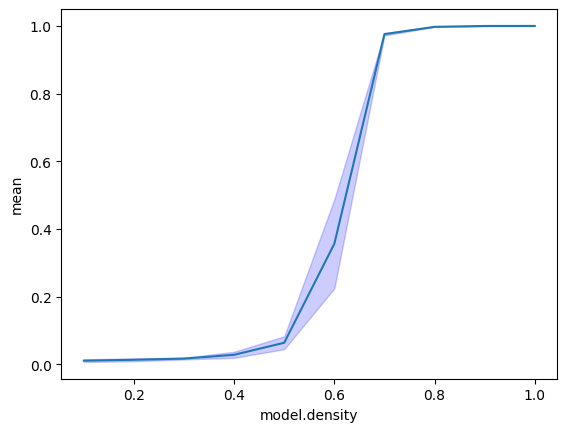

In [17]:
plot_exp_result(exp)